# 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [4]:
data_dir = Path('./data/')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 7
n_class = 3
seed = 17

In [5]:
algo_name = 'lgb_hyperopt'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = data_dir / f'{feature_name}.csv'
p_val_file = data_dir / f'{model_name}.val.csv'
p_tst_file = data_dir / f'{model_name}.tst.csv'
sub_file = data_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 25)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_zi,d_dered_zr,d_dered_zg,d_dered_zu,d_dered_ir,d_dered_ig,d_dered_iu,d_dered_ru,d_dered_gu,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-0.7232,-2.0462,-3.3488,-6.2153,-1.3230,-2.6257,-5.4921,-4.1691,-2.8665,6.1132
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.1016,-0.2767,-0.8698,-1.8317,-0.1751,-0.7683,-1.7302,-1.5550,-0.9619,1.4427
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.0257,-0.1440,-0.3905,-1.3116,-0.1183,-0.3649,-1.2859,-1.1676,-0.9211,1.8205
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-0.2395,-0.5321,-1.4395,-5.7985,-0.2926,-1.2000,-5.5590,-5.2664,-4.3590,1.8640
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-0.3144,-0.9871,-2.5579,-5.8955,-0.6727,-2.2436,-5.5811,-4.9084,-3.3376,4.5471


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 24) (80000, 24)


## Hyperparameter Tuning

In [8]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [10]:
params = {
    "objective": "multiclass",
    "n_estimators": 10000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127, 255]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .5, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100, 173]),
    "max_depth" : hp.choice("max_depth", [30, 63, 125, 255])
}

In [11]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 11.41s/trial, best loss: 0.15504243832852607]
{'objective': 'multiclass', 'n_estimators': 10000, 'subsample_freq': 1, 'random_state': 17, 'n_jobs': -1, 'colsample_bytree': 0.8, 'learning_rate': 0.03634633584994829, 'max_depth': 30, 'min_child_samples': 10, 'num_leaves': 255, 'subsample': 0.8}


## Stratified K-Fold Cross Validation

In [12]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [13]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=100)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.930461
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.884027
[3]	valid_0's multi_logloss: 0.839755
[4]	valid_0's multi_logloss: 0.79758
[5]	valid_0's multi_logloss: 0.761238
[6]	valid_0's multi_logloss: 0.72561
[7]	valid_0's multi_logloss: 0.692545
[8]	valid_0's multi_logloss: 0.663368
[9]	valid_0's multi_logloss: 0.635165
[10]	valid_0's multi_logloss: 0.609493
[11]	valid_0's multi_logloss: 0.585884
[12]	valid_0's multi_logloss: 0.563971
[13]	valid_0's multi_logloss: 0.542554
[14]	valid_0's multi_logloss: 0.524185
[15]	valid_0's multi_logloss: 0.504906
[16]	valid_0's multi_logloss: 0.487261
[17]	valid_0's multi_logloss: 0.470174
[18]	valid_0's multi_logloss: 0.454818
[19]	valid_0's multi_logloss: 0.440049
[20]	valid_0's multi_logloss: 0.426347
[21]	valid_0's multi_logloss: 0.413952
[22]	valid_0's multi_logloss: 0.401929
[23]	valid_0's multi_logloss: 0.391402
[24]	valid_0's multi_loglos

[209]	valid_0's multi_logloss: 0.15226
[210]	valid_0's multi_logloss: 0.152238
[211]	valid_0's multi_logloss: 0.152252
[212]	valid_0's multi_logloss: 0.152242
[213]	valid_0's multi_logloss: 0.152248
[214]	valid_0's multi_logloss: 0.152223
[215]	valid_0's multi_logloss: 0.152206
[216]	valid_0's multi_logloss: 0.152186
[217]	valid_0's multi_logloss: 0.152198
[218]	valid_0's multi_logloss: 0.152187
[219]	valid_0's multi_logloss: 0.152176
[220]	valid_0's multi_logloss: 0.152166
[221]	valid_0's multi_logloss: 0.152141
[222]	valid_0's multi_logloss: 0.152132
[223]	valid_0's multi_logloss: 0.152117
[224]	valid_0's multi_logloss: 0.152111
[225]	valid_0's multi_logloss: 0.152099
[226]	valid_0's multi_logloss: 0.15209
[227]	valid_0's multi_logloss: 0.152076
[228]	valid_0's multi_logloss: 0.152071
[229]	valid_0's multi_logloss: 0.152054
[230]	valid_0's multi_logloss: 0.152053
[231]	valid_0's multi_logloss: 0.152045
[232]	valid_0's multi_logloss: 0.15204
[233]	valid_0's multi_logloss: 0.152033
[23

[70]	valid_0's multi_logloss: 0.188204
[71]	valid_0's multi_logloss: 0.186938
[72]	valid_0's multi_logloss: 0.185686
[73]	valid_0's multi_logloss: 0.184504
[74]	valid_0's multi_logloss: 0.183384
[75]	valid_0's multi_logloss: 0.182305
[76]	valid_0's multi_logloss: 0.181351
[77]	valid_0's multi_logloss: 0.180459
[78]	valid_0's multi_logloss: 0.179502
[79]	valid_0's multi_logloss: 0.178747
[80]	valid_0's multi_logloss: 0.177851
[81]	valid_0's multi_logloss: 0.177155
[82]	valid_0's multi_logloss: 0.176575
[83]	valid_0's multi_logloss: 0.175749
[84]	valid_0's multi_logloss: 0.174993
[85]	valid_0's multi_logloss: 0.174278
[86]	valid_0's multi_logloss: 0.173663
[87]	valid_0's multi_logloss: 0.172948
[88]	valid_0's multi_logloss: 0.172423
[89]	valid_0's multi_logloss: 0.171754
[90]	valid_0's multi_logloss: 0.171257
[91]	valid_0's multi_logloss: 0.170675
[92]	valid_0's multi_logloss: 0.170214
[93]	valid_0's multi_logloss: 0.169829
[94]	valid_0's multi_logloss: 0.169269
[95]	valid_0's multi_logl

[278]	valid_0's multi_logloss: 0.155186
[279]	valid_0's multi_logloss: 0.155216
[280]	valid_0's multi_logloss: 0.155204
[281]	valid_0's multi_logloss: 0.155211
[282]	valid_0's multi_logloss: 0.155203
[283]	valid_0's multi_logloss: 0.155219
[284]	valid_0's multi_logloss: 0.155245
[285]	valid_0's multi_logloss: 0.155276
[286]	valid_0's multi_logloss: 0.155255
[287]	valid_0's multi_logloss: 0.155283
[288]	valid_0's multi_logloss: 0.155275
[289]	valid_0's multi_logloss: 0.155288
[290]	valid_0's multi_logloss: 0.155309
[291]	valid_0's multi_logloss: 0.155305
[292]	valid_0's multi_logloss: 0.15531
[293]	valid_0's multi_logloss: 0.155325
[294]	valid_0's multi_logloss: 0.155337
[295]	valid_0's multi_logloss: 0.155354
[296]	valid_0's multi_logloss: 0.155359
[297]	valid_0's multi_logloss: 0.155355
[298]	valid_0's multi_logloss: 0.15538
[299]	valid_0's multi_logloss: 0.155384
[300]	valid_0's multi_logloss: 0.155382
[301]	valid_0's multi_logloss: 0.155384
[302]	valid_0's multi_logloss: 0.155411
[3

[146]	valid_0's multi_logloss: 0.160421
[147]	valid_0's multi_logloss: 0.160337
[148]	valid_0's multi_logloss: 0.160253
[149]	valid_0's multi_logloss: 0.160188
[150]	valid_0's multi_logloss: 0.160092
[151]	valid_0's multi_logloss: 0.160014
[152]	valid_0's multi_logloss: 0.159947
[153]	valid_0's multi_logloss: 0.159844
[154]	valid_0's multi_logloss: 0.159769
[155]	valid_0's multi_logloss: 0.159689
[156]	valid_0's multi_logloss: 0.159599
[157]	valid_0's multi_logloss: 0.15953
[158]	valid_0's multi_logloss: 0.159497
[159]	valid_0's multi_logloss: 0.15943
[160]	valid_0's multi_logloss: 0.159362
[161]	valid_0's multi_logloss: 0.159301
[162]	valid_0's multi_logloss: 0.159229
[163]	valid_0's multi_logloss: 0.15917
[164]	valid_0's multi_logloss: 0.159096
[165]	valid_0's multi_logloss: 0.159016
[166]	valid_0's multi_logloss: 0.158951
[167]	valid_0's multi_logloss: 0.158895
[168]	valid_0's multi_logloss: 0.15883
[169]	valid_0's multi_logloss: 0.158784
[170]	valid_0's multi_logloss: 0.158746
[171

[4]	valid_0's multi_logloss: 0.797728
[5]	valid_0's multi_logloss: 0.761259
[6]	valid_0's multi_logloss: 0.725728
[7]	valid_0's multi_logloss: 0.692741
[8]	valid_0's multi_logloss: 0.663632
[9]	valid_0's multi_logloss: 0.635471
[10]	valid_0's multi_logloss: 0.6099
[11]	valid_0's multi_logloss: 0.586263
[12]	valid_0's multi_logloss: 0.564389
[13]	valid_0's multi_logloss: 0.54304
[14]	valid_0's multi_logloss: 0.524701
[15]	valid_0's multi_logloss: 0.505483
[16]	valid_0's multi_logloss: 0.487819
[17]	valid_0's multi_logloss: 0.470757
[18]	valid_0's multi_logloss: 0.45543
[19]	valid_0's multi_logloss: 0.440691
[20]	valid_0's multi_logloss: 0.427005
[21]	valid_0's multi_logloss: 0.414676
[22]	valid_0's multi_logloss: 0.402692
[23]	valid_0's multi_logloss: 0.392169
[24]	valid_0's multi_logloss: 0.380716
[25]	valid_0's multi_logloss: 0.371422
[26]	valid_0's multi_logloss: 0.361105
[27]	valid_0's multi_logloss: 0.351791
[28]	valid_0's multi_logloss: 0.342466
[29]	valid_0's multi_logloss: 0.333

[213]	valid_0's multi_logloss: 0.153848
[214]	valid_0's multi_logloss: 0.153851
[215]	valid_0's multi_logloss: 0.153835
[216]	valid_0's multi_logloss: 0.153826
[217]	valid_0's multi_logloss: 0.153841
[218]	valid_0's multi_logloss: 0.153826
[219]	valid_0's multi_logloss: 0.153823
[220]	valid_0's multi_logloss: 0.153827
[221]	valid_0's multi_logloss: 0.153828
[222]	valid_0's multi_logloss: 0.153842
[223]	valid_0's multi_logloss: 0.153821
[224]	valid_0's multi_logloss: 0.153802
[225]	valid_0's multi_logloss: 0.15378
[226]	valid_0's multi_logloss: 0.153764
[227]	valid_0's multi_logloss: 0.153744
[228]	valid_0's multi_logloss: 0.153733
[229]	valid_0's multi_logloss: 0.153757
[230]	valid_0's multi_logloss: 0.153762
[231]	valid_0's multi_logloss: 0.153783
[232]	valid_0's multi_logloss: 0.153774
[233]	valid_0's multi_logloss: 0.153767
[234]	valid_0's multi_logloss: 0.15374
[235]	valid_0's multi_logloss: 0.153739
[236]	valid_0's multi_logloss: 0.15373
[237]	valid_0's multi_logloss: 0.153716
[23

[61]	valid_0's multi_logloss: 0.20294
[62]	valid_0's multi_logloss: 0.201428
[63]	valid_0's multi_logloss: 0.199959
[64]	valid_0's multi_logloss: 0.198198
[65]	valid_0's multi_logloss: 0.196504
[66]	valid_0's multi_logloss: 0.194869
[67]	valid_0's multi_logloss: 0.193352
[68]	valid_0's multi_logloss: 0.191821
[69]	valid_0's multi_logloss: 0.190443
[70]	valid_0's multi_logloss: 0.189201
[71]	valid_0's multi_logloss: 0.187913
[72]	valid_0's multi_logloss: 0.186659
[73]	valid_0's multi_logloss: 0.185441
[74]	valid_0's multi_logloss: 0.184274
[75]	valid_0's multi_logloss: 0.183135
[76]	valid_0's multi_logloss: 0.182196
[77]	valid_0's multi_logloss: 0.18132
[78]	valid_0's multi_logloss: 0.180334
[79]	valid_0's multi_logloss: 0.179623
[80]	valid_0's multi_logloss: 0.178722
[81]	valid_0's multi_logloss: 0.178036
[82]	valid_0's multi_logloss: 0.177475
[83]	valid_0's multi_logloss: 0.176665
[84]	valid_0's multi_logloss: 0.175903
[85]	valid_0's multi_logloss: 0.175163
[86]	valid_0's multi_loglos

[268]	valid_0's multi_logloss: 0.154513
[269]	valid_0's multi_logloss: 0.154501
[270]	valid_0's multi_logloss: 0.154513
[271]	valid_0's multi_logloss: 0.154536
[272]	valid_0's multi_logloss: 0.15455
[273]	valid_0's multi_logloss: 0.154539
[274]	valid_0's multi_logloss: 0.154547
[275]	valid_0's multi_logloss: 0.154561
[276]	valid_0's multi_logloss: 0.154572
[277]	valid_0's multi_logloss: 0.154577
[278]	valid_0's multi_logloss: 0.154588
[279]	valid_0's multi_logloss: 0.154583
[280]	valid_0's multi_logloss: 0.154586
[281]	valid_0's multi_logloss: 0.154574
[282]	valid_0's multi_logloss: 0.154575
[283]	valid_0's multi_logloss: 0.154583
[284]	valid_0's multi_logloss: 0.154603
[285]	valid_0's multi_logloss: 0.154591
[286]	valid_0's multi_logloss: 0.154584
[287]	valid_0's multi_logloss: 0.154626
[288]	valid_0's multi_logloss: 0.154622
[289]	valid_0's multi_logloss: 0.154623
[290]	valid_0's multi_logloss: 0.154639
[291]	valid_0's multi_logloss: 0.154619
[292]	valid_0's multi_logloss: 0.154627
[

[120]	valid_0's multi_logloss: 0.160917
[121]	valid_0's multi_logloss: 0.160715
[122]	valid_0's multi_logloss: 0.160547
[123]	valid_0's multi_logloss: 0.160325
[124]	valid_0's multi_logloss: 0.160172
[125]	valid_0's multi_logloss: 0.15999
[126]	valid_0's multi_logloss: 0.15981
[127]	valid_0's multi_logloss: 0.15964
[128]	valid_0's multi_logloss: 0.159477
[129]	valid_0's multi_logloss: 0.159321
[130]	valid_0's multi_logloss: 0.159167
[131]	valid_0's multi_logloss: 0.158987
[132]	valid_0's multi_logloss: 0.158837
[133]	valid_0's multi_logloss: 0.158723
[134]	valid_0's multi_logloss: 0.158584
[135]	valid_0's multi_logloss: 0.15848
[136]	valid_0's multi_logloss: 0.158338
[137]	valid_0's multi_logloss: 0.158205
[138]	valid_0's multi_logloss: 0.158067
[139]	valid_0's multi_logloss: 0.157935
[140]	valid_0's multi_logloss: 0.157833
[141]	valid_0's multi_logloss: 0.157735
[142]	valid_0's multi_logloss: 0.157629
[143]	valid_0's multi_logloss: 0.157518
[144]	valid_0's multi_logloss: 0.157383
[145

[329]	valid_0's multi_logloss: 0.154544
[330]	valid_0's multi_logloss: 0.154554
[331]	valid_0's multi_logloss: 0.154571
[332]	valid_0's multi_logloss: 0.154573
[333]	valid_0's multi_logloss: 0.154571
[334]	valid_0's multi_logloss: 0.154574
[335]	valid_0's multi_logloss: 0.154599
[336]	valid_0's multi_logloss: 0.15462
[337]	valid_0's multi_logloss: 0.154643
[338]	valid_0's multi_logloss: 0.154649
[339]	valid_0's multi_logloss: 0.154681
[340]	valid_0's multi_logloss: 0.154667
[341]	valid_0's multi_logloss: 0.154665
[342]	valid_0's multi_logloss: 0.154667
[343]	valid_0's multi_logloss: 0.15469
[344]	valid_0's multi_logloss: 0.154713
[345]	valid_0's multi_logloss: 0.154708
[346]	valid_0's multi_logloss: 0.154711
[347]	valid_0's multi_logloss: 0.154716
[348]	valid_0's multi_logloss: 0.154717
[349]	valid_0's multi_logloss: 0.154732
[350]	valid_0's multi_logloss: 0.154765
[351]	valid_0's multi_logloss: 0.154761
[352]	valid_0's multi_logloss: 0.154776
[353]	valid_0's multi_logloss: 0.154793
[3

[168]	valid_0's multi_logloss: 0.157209
[169]	valid_0's multi_logloss: 0.157163
[170]	valid_0's multi_logloss: 0.157134
[171]	valid_0's multi_logloss: 0.15709
[172]	valid_0's multi_logloss: 0.157023
[173]	valid_0's multi_logloss: 0.156977
[174]	valid_0's multi_logloss: 0.156951
[175]	valid_0's multi_logloss: 0.156923
[176]	valid_0's multi_logloss: 0.156892
[177]	valid_0's multi_logloss: 0.156827
[178]	valid_0's multi_logloss: 0.156804
[179]	valid_0's multi_logloss: 0.156746
[180]	valid_0's multi_logloss: 0.156717
[181]	valid_0's multi_logloss: 0.156663
[182]	valid_0's multi_logloss: 0.156653
[183]	valid_0's multi_logloss: 0.156637
[184]	valid_0's multi_logloss: 0.156606
[185]	valid_0's multi_logloss: 0.156577
[186]	valid_0's multi_logloss: 0.156562
[187]	valid_0's multi_logloss: 0.156544
[188]	valid_0's multi_logloss: 0.156508
[189]	valid_0's multi_logloss: 0.156494
[190]	valid_0's multi_logloss: 0.156456
[191]	valid_0's multi_logloss: 0.156438
[192]	valid_0's multi_logloss: 0.156407
[

In [14]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.5350%


In [15]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [16]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

<AxesSubplot:ylabel='feature'>

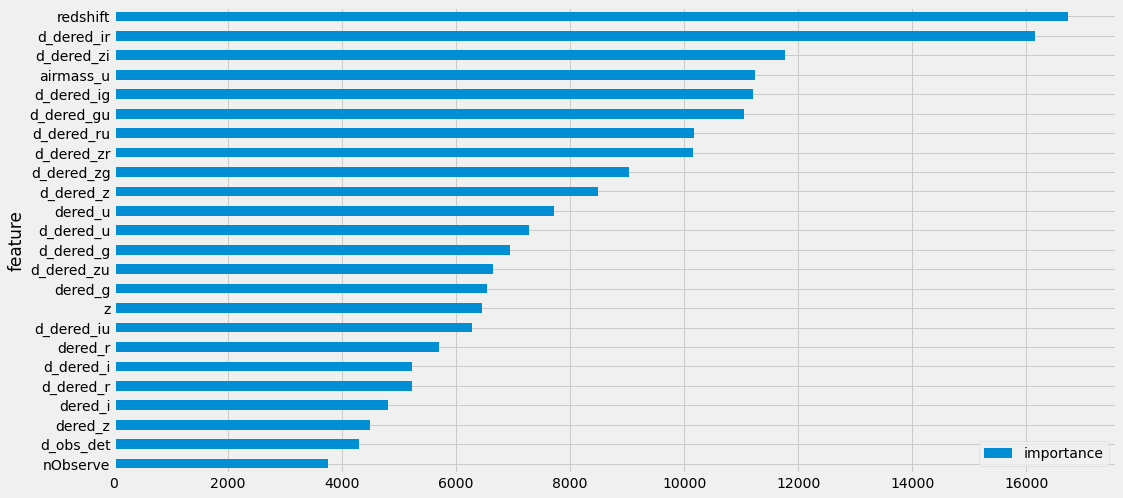

In [17]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [18]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [19]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [20]:
sub[target_col].value_counts()

2    40730
0    29970
1     9300
Name: class, dtype: int64

In [21]:
sub.to_csv(sub_file)